## <span style="color: blue; font-weight:bold">  Lending Club Loan Data Analysis 
### <span style="color: blue">  DL prediction model

### <span style="color: green; font-weight:bold">  Import Relevant Libraries

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.metrics import AUC, Precision, Recall

### <span style="color: green; font-weight:bold">  Custom functions used in the project

In [7]:
#################---- Summary of EDA ----#########################
def summary(df_csv):
    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        "Data Type": df_csv.dtypes,
        "Memory Used": df_csv.memory_usage(deep=True),
        "Nunique": df_csv.nunique(),
        "Max": df_csv.select_dtypes(include='number').max(),
        "Min": df_csv.select_dtypes(include='number').min(),
        "Missing": df_csv.isnull().sum(),
        'Whitespace': df_csv.map(lambda x: isinstance(x, str) and x.strip() == '').sum()
    })

    summary_df["Min"] = summary_df["Min"].fillna("N/A")
    summary_df["Max"] = summary_df["Max"].fillna("N/A")
    return summary_df

#################################################################

In [8]:
#################---- Check Duplecates ----#########################
def check_duplicates(df):
    has_duplicates = df.duplicated(keep=False).any()
    print(f"Has duplicates: {has_duplicates}")
    print(f"Total number of duplicated rows: {df.duplicated(keep=False).sum()}")

    # How many rows occur 2, 3, 4+ times.
    if df.duplicated(keep=False).sum() != 0 :
        df_duplicated = df[df.duplicated(keep=False)]
        print(df_duplicated.value_counts().value_counts())
        # Remove duplicates (keep first occurrence) and return cleaned DataFrame
        df = df.drop_duplicates(keep='first')
        print(f"Data set is cleaned")
    else:
        print(f"data set unmodified")
    return df
#################################################################

In [2]:
############# Distribution of all numeric features #################
def plot_numeric_distributions(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    df[numeric_cols].hist(
        bins=30, 
        figsize=(10, len(numeric_cols)), 
        layout=(len(numeric_cols) // 3 + 1, 3), 
        edgecolor='black'
    )
    
    plt.tight_layout()
    plt.show()
#################################################################

In [3]:
########### Correlation Matrix ##########################
def corr_matrix(df):
    correlation_matrix= df.corr()
    plt.figure(figsize=(8, 6)) # Adjust figure size as needed
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix')
    plt.show()
#########################################################

In [2]:
########### Correlation Analysis ##########################
def correlation_analysis(df, threshold=0.5):
    """
    Analyze correlations and identify highly correlated features
    """
    corr_matrix = df.corr().abs()
    
    # Find pairs of highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                high_corr_pairs.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j], 
                    'correlation': corr_matrix.iloc[i, j]
                })
    
    return pd.DataFrame(high_corr_pairs)
############################################################

In [3]:
# Data loading
df = pd.read_csv('loan_data.csv')

In [13]:
# Check the first five variables of the dataframe
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [14]:
'''
Summary data_set_info - check the output and clean Missing and Whitespace if needed
'''
summary(df)

,Data Type,Memory Used,Nunique,Max,Min,Missing,Whitespace
Index,NaN,132,NaN,N/A,N/A,NaN,NaN
credit.policy,int64,76624,2.0,1.0,0.0,0.0,0.0
days.with.cr.line,float64,76624,2687.0,17639.95833,178.958333,0.0,0.0
delinq.2yrs,int64,76624,11.0,13.0,0.0,0.0,0.0
dti,float64,76624,2529.0,29.96,0.0,0.0,0.0
fico,int64,76624,44.0,827.0,612.0,0.0,0.0
inq.last.6mths,int64,76624,28.0,33.0,0.0,0.0,0.0
installment,float64,76624,4788.0,940.14,15.67,0.0,0.0
int.rate,float64,76624,249.0,0.2164,0.06,0.0,0.0
log.annual.inc,float64,76624,1987.0,14.528354,7.547502,0.0,0.0


In [15]:
# Check for duplicates - the functun will clean duplicated rows
df = check_duplicates(df)

Has duplicates: False
Total number of duplicated rows: 0
data set unmodified


In [16]:
# See the data types of variables in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [17]:
# Dataset statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
credit.policy,9578.0,0.804970,0.396245,0.000000,1.000000,1.000000,1.000000,1.000000e+00
int.rate,9578.0,0.122640,0.026847,0.060000,0.103900,0.122100,0.140700,2.164000e-01
installment,9578.0,319.089413,207.071301,15.670000,163.770000,268.950000,432.762500,9.401400e+02
log.annual.inc,9578.0,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,1.452835e+01
dti,9578.0,12.606679,6.883970,0.000000,7.212500,12.665000,17.950000,2.996000e+01
fico,9578.0,710.846314,37.970537,612.000000,682.000000,707.000000,737.000000,8.270000e+02
days.with.cr.line,9578.0,4560.767197,2496.930377,178.958333,2820.000000,4139.958333,5730.000000,1.763996e+04
revol.bal,9578.0,16913.963876,33756.189557,0.000000,3187.000000,8596.000000,18249.500000,1.207359e+06
revol.util,9578.0,46.799236,29.014417,0.000000,22.600000,46.300000,70.900000,1.190000e+02
inq.last.6mths,9578.0,1.577469,2.200245,0.000000,0.000000,1.000000,2.000000,3.300000e+01


In [18]:
# Check the target variable
df['not.fully.paid'].value_counts(1)

not.fully.paid
0    0.839946
1    0.160054
Name: proportion, dtype: float64

### <span style="color: red; font-weight:bold"> Severe class imbalance (5.25:1 ratio) would bias model toward majority class

In [19]:
# Handling imbalanced dataset using UPSAMPLE technique
not_fully_paid_0 = df[df['not.fully.paid'] == 0]
not_fully_paid_1 = df[df['not.fully.paid'] == 1]

print('not_fully_paid_0', not_fully_paid_0.shape)
print('not_fully_paid_1', not_fully_paid_1.shape)

#handling imbalanced data
from sklearn.utils import resample
df_minority_upsampled = resample(not_fully_paid_1, replace = True, n_samples = 8045)
df = pd.concat([not_fully_paid_0, df_minority_upsampled])

from sklearn.utils import shuffle
df = shuffle(df)

not_fully_paid_0 (8045, 14)
not_fully_paid_1 (1533, 14)


In [20]:
# Check the target variable again
df['not.fully.paid'].value_counts()

not.fully.paid
0    8045
1    8045
Name: count, dtype: int64

### <span style="color: red; font-weight:bold">  Label_encoder ==> save for DEPLOY

In [21]:
# Label Encoding categorical
label_encoder = LabelEncoder()
df['purpose'] = label_encoder.fit_transform(df['purpose'])

# Save 
joblib.dump(label_encoder, 'encoder.pkl')

['encoder.pkl']

In [22]:
df['purpose'].value_counts().sort_index()

purpose
0    3904
1    1924
2    6530
3     654
4    1084
5     649
6    1345
Name: count, dtype: int64

### <span style="color: green; font-weight:bold">  Correlation between features

In [23]:
correlation_analysis(df)

,feature1,feature2,correlation
0,credit.policy,inq.last.6mths,0.531631
1,int.rate,fico,0.680587
2,fico,revol.util,0.502768


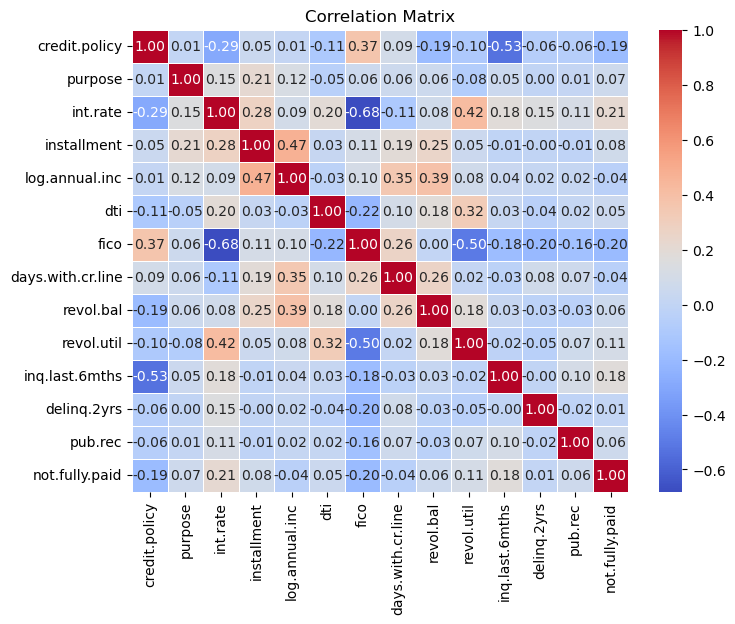

In [24]:
corr_matrix(df)

### <span style="color: green; font-weight:bold">  Seggregate the features & target

In [25]:
# Features
X = df.drop(columns='not.fully.paid')
# Target
y = df['not.fully.paid']

#### <span style="color: grey">Data set has ---> 14 columns and 9578 rows, data types: float - 6 columns, int - 7, object - 1
#### <span style="color: grey">Target values are 20% x 80% imbalance ---> Fixed
#### <span style="color: grey">Correlation ---> not critical for DL model

In [26]:
X.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
6823,1,2,0.1496,796.84,11.571666,8.37,687,5702.041667,13843,38.2,3,1,0
3115,1,0,0.0768,265.13,10.257659,2.23,712,1499.958333,2204,19.2,0,0,0
4571,1,2,0.1426,240.15,11.156251,18.82,692,5490.000000,16120,96.5,3,0,0
1137,1,2,0.1197,249.00,11.139598,21.63,692,5130.000000,30245,40.8,2,0,0
5335,1,4,0.0894,571.89,11.695247,3.44,797,7529.958333,21807,43.6,0,0,0


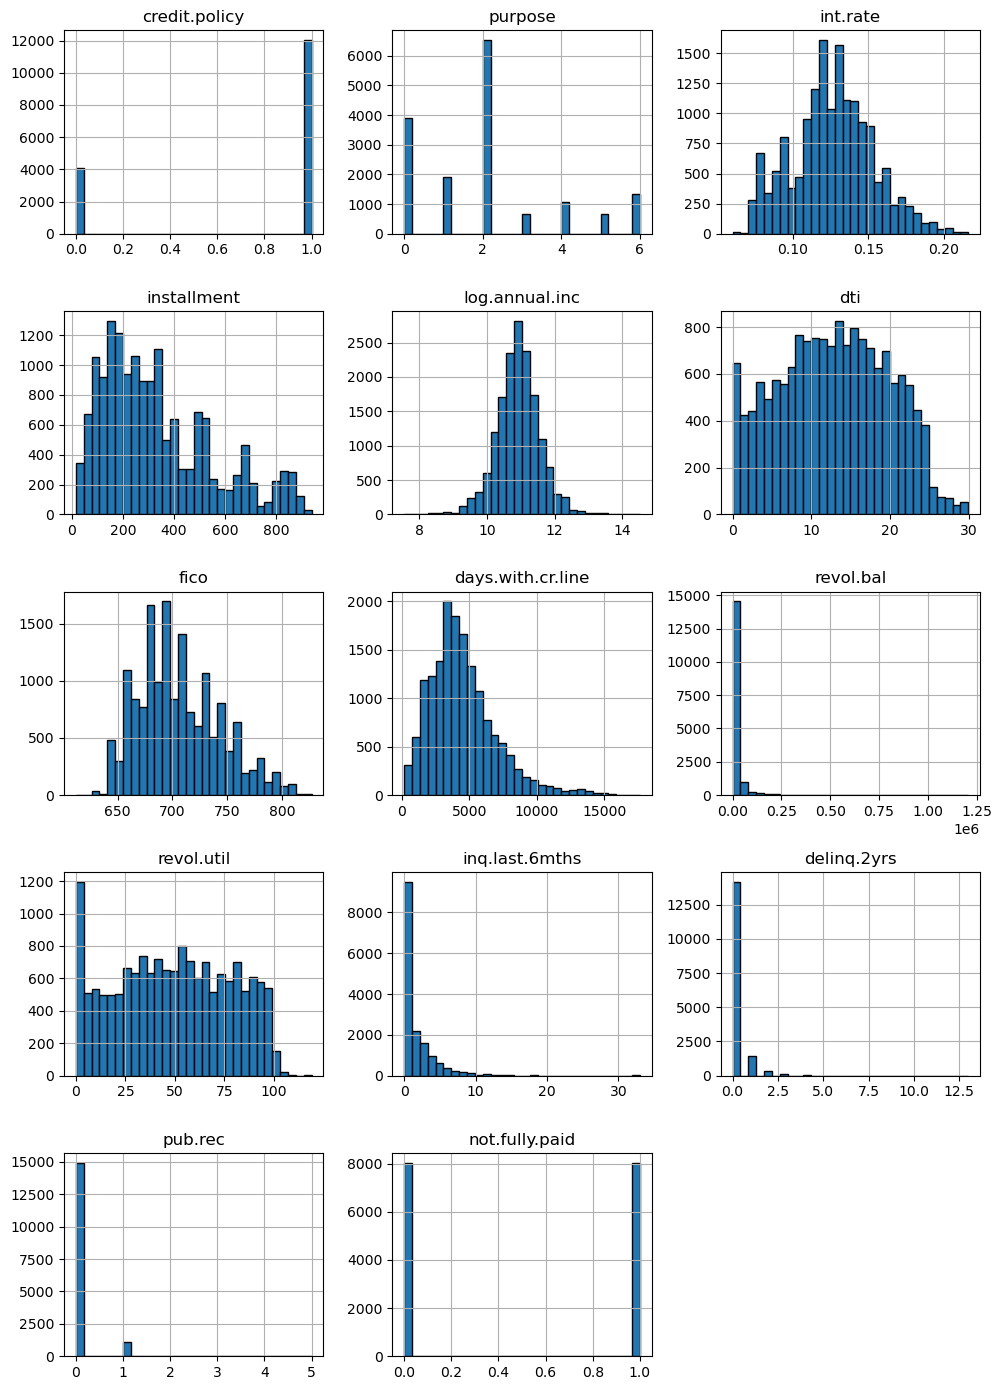

In [27]:
# Plot histograms for all numeric columns in a DataFrame
plot_numeric_distributions(df)

### <span style="color: green; font-weight:bold">RobustScaler() only for "continuous_features"

In [28]:
# Only scale continuous features
continuous_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
                      'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec']

# Get remaining columns (non-continuous features)
other_features = [col for col in X.columns if col not in continuous_features]

# Create scaler - transformer
scaler = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), continuous_features),
        ('passthrough', 'passthrough', other_features)
    ]
)

# Fit and transform
X_scaled = scaler.fit_transform(X)  # X_scaled is np.array

# Get feature names
scaled_features = continuous_features + other_features
# Convert to DataFrame
X_df_scaled = pd.DataFrame(X_scaled, columns=scaled_features)

### <span style="color: red; font-weight:bold">  Scaler => save for DEPLOY

In [29]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

### <span style="color: green; font-weight:bold">  Train Validation Test Split

In [30]:
# 3-ways stratified train/val/test splits function
def train_val_test(X, y, test_size=0.2, val_size=0.2, random_state=42):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = val_size/(1 - test_size), random_state = random_state, stratify = y_temp)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [31]:
#  TrainSet-> 60%, TestSet->20%, ValidationSet->20%
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(X_df_scaled, y)

In [32]:
# Check the shape of the sets
X_train.shape, X_test.shape, X_val.shape

((9654, 13), (3218, 13), (3218, 13))

In [33]:
# Check class distribution
print("Class distribution:")
print(y_test.value_counts(1))

Class distribution:
not.fully.paid
1    0.5
0    0.5
Name: proportion, dtype: float64


## <span style="color: blue; font-weight:bold">   Create a DL model using Keras with Tensorflow backend.

In [34]:
# Disable oneDNN optimizations to avoid potential minor numerical differences caused by floating-point round-off errors.
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [35]:
# Import TensorFlow and Keras libraries
import tensorflow as tf
import keras
from keras import layers
import keras_tuner
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

hp = keras_tuner.HyperParameters()
layers = tf.keras.layers

# Install keras-tuner if needed:  !pip install keras-tuner -q

In [37]:
# convert the numpy arrays to tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int64)

X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int64)

X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.int64)

In [38]:
X_train_tensor.shape[1]

13

# <span style="color: orange; font-weight:bold"> Build the Model

## <span style="color: green; font-weight:bold"> Build a Keras Sequential model with the following layers:
    • 3 x (Dense + BatchNormalization + Activation + Dropout) layers blocks
    • 1 x (Boolean  + BatchNormalization + Activation + Dropout) layers block for better performents
    • 3 BatchNormalization layers callbacks
    • Callbacks with EarlyStopping and ReduceLROnPlateau to privent model overfitteng and learning rate parameter regulationCallbacks with EarlyStopping and ReduceLROnPlateau to privent model overfitteng and learning rate reguliration
    • Tuning hyperparameters  to determine the best model configuration

In [39]:
# Define a sequential model in TensorFlow
def build_model(hp):
    
    model = tf.keras.Sequential()

#=========================================-1-====================================================

    # First hidden Layer 
    model.add(layers.Dense(
        
        # Tune number of units
        units=hp.Int("units_1", min_value=128, max_value=256, step=32),
        input_shape=(X_train_tensor.shape[1],),
    ))
# BatchNormalization Layer
    model.add(layers.BatchNormalization())
# Tune the activation function to Choose.
    model.add(layers.Activation(
        activation=hp.Choice("activation_1", ["relu", "tanh", "elu"])
    ))
# Add Dropout Layer
    model.add(layers.Dropout(hp.Float("dropout_1", min_value=0.2, max_value=0.5, step=0.1)))

#=========================================-2-====================================================

# Second hidden Layer 
    model.add(layers.Dense(
        # Tune number of units
        units=hp.Int("units_2", min_value=128, max_value=256, step=32)
    ))
# BatchNormalization Layer
    model.add(layers.BatchNormalization())
# Tune the activation function to Choose.
    model.add(layers.Activation(
        activation=hp.Choice("activation_2", ["relu", "tanh", "elu"])
    ))
# Add Dropout Layer
    model.add(layers.Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.3, step=0.1)))

#=========================================-3-====================================================

# Third hidden Layer 
    model.add(layers.Dense(
        # Tune number of units
        units=hp.Int("units_3", min_value=67, max_value=128, step=32)
    ))
# BatchNormalization Layer
    model.add(layers.BatchNormalization())
# Tune the activation function to Choose.
    model.add(layers.Activation(
        activation=hp.Choice("activation_3", ["relu", "tanh", "elu"])
    ))
# Add Dropout Layer
    model.add(layers.Dropout(hp.Float("dropout_3", min_value=0.1, max_value=0.3, step=0.1)))

#=========================================-4-====================================================
# Boolean fidden layer 
    if hp.Boolean("use_boolean_layer"):
        model.add(layers.Dense(
# Tune number of units
            units=hp.Int("units_extra", min_value=32, max_value=128, step=32)
        ))
# BatchNormalization Layer
        model.add(layers.BatchNormalization())
# Tune the activation function to Choose.
        model.add(layers.Activation(
            activation=hp.Choice("activation_extra", ["relu", "tanh", "elu"])
        ))
# Add Dropout Layer
        model.add(layers.Dropout(hp.Float("dropout_extra", min_value=0.1, max_value=0.3, step=0.1)))
        

#=========================================-Output layer-====================================================
# Output layer
    model.add(layers.Dense(1, activation='sigmoid'))


  # Optimizer & learning rate
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop"])
    
    if optimizer_choice == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer = optimizer,
        loss="binary_crossentropy",
        metrics=['accuracy']
    )

    return model


## <span style="color: green; font-weight:bold"> Set up a callbackes and tuning Hyperparameters

In [40]:
# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)
]

# Create tuner
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=25,
    directory='project_DL',
    project_name='lending_club'
)

# Search the best Hyperparameters
tuner.search(
    X_train_tensor, y_train_tensor,
    epochs=20,
    batch_size=32,        
    validation_data=(X_val_tensor, y_val_tensor),
    callbacks=callbacks,
    verbose=1
)


Trial 25 Complete [00h 00m 40s]
val_accuracy: 0.6510254740715027

Best val_accuracy So Far: 0.6631448268890381
Total elapsed time: 00h 13m 36s


## <span style="color: green; font-weight:bold"> Geta te best model and show the best tuning Hyperparameters

In [41]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# View best hyperparameters
for param in best_hyperparameters.space:
    print(f"{param.name}: {best_hyperparameters.get(param.name)}")

units_1: 128
activation_1: tanh
dropout_1: 0.2
units_2: 192
activation_2: relu
dropout_2: 0.2
units_3: 67
activation_3: relu
dropout_3: 0.1
use_boolean_layer: True
lr: 0.008245455835525111
optimizer: adam
units_extra: 64
activation_extra: elu
dropout_extra: 0.1


## <span style="color: green; font-weight:bold"> Summary of the best model Layers architecture and total parameters used to train

In [42]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 67)             │        12,931 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 67)             │           268 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 67)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 67)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,712 (178.56 KB)

 Trainable params: 44,810 (175.04 KB)

 Non-trainable params: 902 (3.52 KB)

## <span style="color: green; font-weight:bold"> Train the best model on 100 epochs with callback

In [43]:
# Train the model
history = best_model.fit(
    X_train_tensor, y_train_tensor,
    epochs=100, 
    batch_size=32,
    callbacks=callbacks,
    verbose=2, 
    validation_data=(X_val_tensor, y_val_tensor))

Epoch 1/100
302/302 - 3s - 9ms/step - accuracy: 0.6648 - loss: 0.6111 - val_accuracy: 0.6659 - val_loss: 0.5986 - learning_rate: 0.0082
Epoch 2/100
302/302 - 2s - 5ms/step - accuracy: 0.6639 - loss: 0.6080 - val_accuracy: 0.6526 - val_loss: 0.6055 - learning_rate: 0.0082
Epoch 3/100
302/302 - 1s - 5ms/step - accuracy: 0.6649 - loss: 0.6049 - val_accuracy: 0.6647 - val_loss: 0.6022 - learning_rate: 0.0082
Epoch 4/100
302/302 - 1s - 5ms/step - accuracy: 0.6747 - loss: 0.6003 - val_accuracy: 0.6644 - val_loss: 0.5949 - learning_rate: 0.0082
Epoch 5/100
302/302 - 2s - 5ms/step - accuracy: 0.6750 - loss: 0.5988 - val_accuracy: 0.6666 - val_loss: 0.5944 - learning_rate: 0.0082
Epoch 6/100
302/302 - 1s - 5ms/step - accuracy: 0.6727 - loss: 0.5984 - val_accuracy: 0.6666 - val_loss: 0.5911 - learning_rate: 0.0082
Epoch 7/100
302/302 - 1s - 5ms/step - accuracy: 0.6764 - loss: 0.5962 - val_accuracy: 0.6709 - val_loss: 0.5888 - learning_rate: 0.0082
Epoch 8/100
302/302 - 2s - 5ms/step - accuracy: 

## <span style="color: green; font-weight:bold"> Visualization the training process

In [44]:
def visualization(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.show()

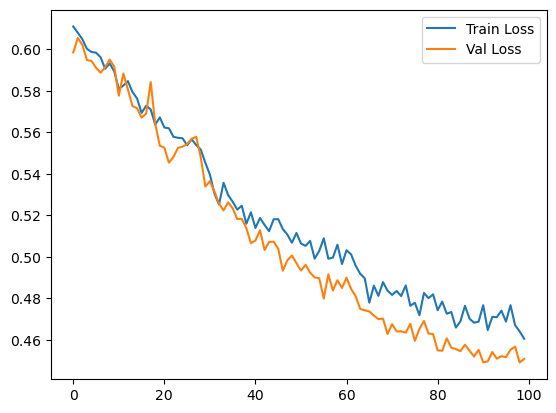

In [45]:
# Plot the result
visualization(history)

### <span style="color: red; font-weight:bold">   Freeze the model

In [46]:
# Save the model for the future deployment
best_model.save('Lending_Club_best_model.keras')  

### <span style="color: green; font-weight:bold"> Evaluate the trained model on the test dataset

In [47]:
# Evaluate
test_loss, test_accuracy = best_model.evaluate(X_test_tensor, y_test_tensor)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7949 - loss: 0.4388


In [48]:
# The first number represents the average loss or error of the model's predictions on the test data.
# The second number represents the accuracy of the model on the test data.
print(f'Test loss: {test_loss: 4f}')
print(f'Test accuracy: {test_accuracy: 4f}')

Test loss:  0.438822
Test accuracy:  0.794904


### <span style="color: green; font-weight:bold"> Get the predictions on test data

In [49]:
# Get the predictions
y_test_predict = best_model.predict(X_test_tensor)
y_test_predict[0:10]

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[0.7906137 ],
       [0.9676527 ],
       [0.31199506],
       [0.23368254],
       [0.0408994 ],
       [0.44524524],
       [0.29515323],
       [0.01057087],
       [0.8900563 ],
       [0.11291798]], dtype=float32)

### <span style="color: green; font-weight:bold"> Convert the predictions to binary integers (0, 1)

In [50]:
# convert the predictions to binary integers using a threshold of 0.5
y_test_predict = (y_test_predict > 0.5).astype(int)

In [51]:
y_test_predict[0:10]

array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]])

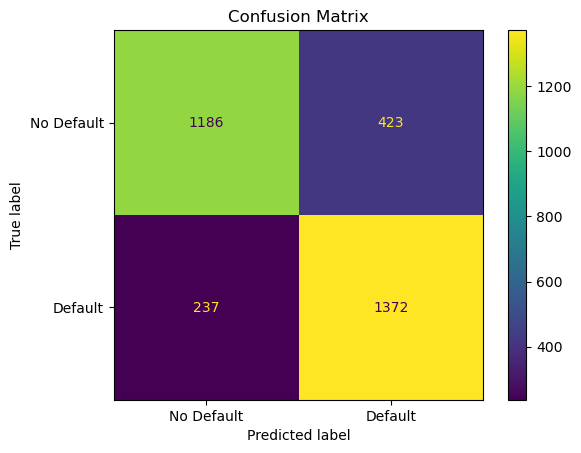

In [52]:
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_tensor, y_test_predict, display_labels=["No Default", "Default"]);
plt.title("Confusion Matrix")
plt.show()

### <span style="color: green; font-weight:bold"> Detailed Classification Report

In [53]:
# Calculate additional metrics
test_auc = roc_auc_score(y_test, y_test_predict)
print(f'Test AUC-ROC: {test_auc:.4f}')

y_test_true = y_test_tensor.numpy()  
print("\n" + "="*70)
print("Classification Report:")
print("="*70)
print(classification_report(y_test_true, y_test_predict, target_names=['No Default (0)', 'Default (1)']))
print("\n" + "="*70)
print("Confusion Matrix:")
print("="*70)
print(confusion_matrix(y_test_true, y_test_predict))

Test AUC-ROC: 0.7949

Classification Report:
                precision    recall  f1-score   support

No Default (0)       0.83      0.74      0.78      1609
   Default (1)       0.76      0.85      0.81      1609

      accuracy                           0.79      3218
     macro avg       0.80      0.79      0.79      3218
  weighted avg       0.80      0.79      0.79      3218


Confusion Matrix:
[[1186  423]
 [ 237 1372]]
